In [1]:
import numpy as np
from astropy.time import Time

def prepare_and_save_real_data_adjusted(
    data_path,
    save_file_path,
    keys=['X', 'NIR', 'IR', 'Sub-mm'],
    mask_eval_fraction=0.2
):
    """
    Prepares, standardizes, and masks a specified fraction of real observed data for evaluation.
    Saves all values in their standardized form.

    Args:
        data_path (str): Directory with raw data files.
        save_file_path (str): Base path to save output npz files.
        keys (list): Names of each channel.
        mask_eval_fraction (float): Fraction of observed data to mask per channel.
    """

    data_dict = {}
    eval_ground_truth = {}
    max_time = 0

    # Load raw data and align time axis
    for key in keys:
        if key == 'X':
            file = data_path + '0718chan.dat'
            df = np.genfromtxt(file)
            bmjd, flux = df[:, 0], df[:, 1]
        elif key == 'NIR':
            file = data_path + '0718grav.dat'
            df = np.genfromtxt(file)
            bmjd, flux = df[:, 0], df[:, 1]
        elif key == 'IR':
            file = data_path + '0718sptz.dat'
            df = np.genfromtxt(file)
            bmjd, flux = df[:, 0], df[:, 2] * 1e3
        elif key == 'Sub-mm':
            file = data_path + '0718alma.dat'
            df = np.genfromtxt(file, delimiter=' ')
            bmjd, flux = df[:, 2], df[:, 3]
        else:
            raise ValueError(f"Unknown key: {key}")

        time = Time(bmjd, format='mjd', scale='tcb').utc.to_datetime()
        start_time = min(time)
        minutes_since_start = np.array([(t - start_time).total_seconds() / 60 for t in time])

        data_dict[key] = {
            'time': minutes_since_start,
            'flux': flux
        }

        max_time = max(max_time, int(max(minutes_since_start)) + 1)

    # Build a standardized array with mask
    channels = len(keys)
    data = np.zeros((1, max_time, channels * 2 + 1))  # +1 for time channel

    for j, key in enumerate(keys):
        minutes = data_dict[key]['time'].astype(int)
        flux = data_dict[key]['flux']

        data[0, minutes, j] = flux
        data[0, minutes, channels + j] = 1  # Observed mask

    # Standardize each channel
    for j, key in enumerate(keys):
        channel_data = data[0, :, j]
        observed = data[0, :, channels + j] == 1
        if np.any(observed):
            mean = np.mean(channel_data[observed])
            std = np.std(channel_data[observed])
            std = std if std > 0 else 1.0  # Avoid division by zero
            data[0, :, j] = (channel_data - mean) / std

    # Mask a fraction of observed points for evaluation and store only them
    for j, key in enumerate(keys):
        observed_indices = np.where(data[0, :, channels + j] == 1)[0]
        num_to_mask = int(len(observed_indices) * mask_eval_fraction)
        if num_to_mask == 0:
            continue

        selected_indices = np.random.choice(observed_indices, num_to_mask, replace=False)

        # Store standardized times and flux values of masked points
        masked_times = selected_indices
        standardized_values = data[0, masked_times, j] # Already standardized

        eval_ground_truth[key] = {
            'times': masked_times,
            'values': standardized_values
        }

        # Mask them in the data
        data[0, masked_times, channels + j] = 0

    # Fill normalized time channel (e.g. for TripletFormer)
    data[0, :, -1] = np.linspace(0, 1, max_time)

    # Save full data
    np.savez(save_file_path, real_data=data)

    # Save MOGP version (without time channel)
    np.savez(save_file_path.replace('.npz', '_mogp.npz'), real_data=data[:, :, :-1])

    # Save only ground truth values and times for evaluation
    np.savez(save_file_path.replace('.npz', '_eval_ground_truth.npz'),
             **eval_ground_truth, allow_pickle=True)

    return data

In [2]:
import numpy as np
from scipy.stats import norm

def compute_coverage(lower, upper, gt_values):
    """
    Computes the proportion of ground truth values that fall within the given interval.
    """
    return np.mean((gt_values >= lower) & (gt_values <= upper))


def compute_coverage_at_percentage(mean_preds, std_preds, gt_values, coverage_percentage):
    sigma_multiplier = norm.ppf(1 - (1 - coverage_percentage) / 2)
    lower_bound = mean_preds - sigma_multiplier * std_preds
    upper_bound = mean_preds + sigma_multiplier * std_preds
    return np.mean((gt_values >= lower_bound) & (gt_values <= upper_bound))


def calculate_model_coverage_across_percentages(model_files, gt_file, keys, coverage_percentages):
    gt = np.load(gt_file, allow_pickle=True)
    coverage_results = {model_name: [] for model_name in model_files.keys()}

    for coverage in coverage_percentages:
        model_coverage_across_keys = {model_name: [] for model_name in model_files.keys()}

        for key in keys:
            if key not in gt:
                continue

            gt_item = gt[key].item()
            gt_times = gt_item['times']
            gt_values = gt_item['values']

            for model_name, file_path in model_files.items():
                model_data = np.load(file_path, allow_pickle=True)
                test_x = model_data[f"{key}_test_x"].squeeze()
                mean_preds = model_data[f"{key}_predicted_means"]
                upper_bound_95 = model_data[f"{key}_upper_bound"]
                lower_bound_95 = model_data[f"{key}_lower_bound"]

                sigma_multiplier_95 = norm.ppf(0.975)
                std_preds = (upper_bound_95 - lower_bound_95) / (2 * sigma_multiplier_95)

                idx_map = {int(t): idx for idx, t in enumerate(test_x)}
                matched_pred_indices = [idx_map[int(t)] for t in gt_times if int(t) in idx_map]
                matched_gt_values = [gt_values[i] for i, t in enumerate(gt_times) if int(t) in idx_map]

                if len(matched_pred_indices) > 0:
                    mean_preds_matched = mean_preds[matched_pred_indices]
                    std_preds_matched = std_preds[matched_pred_indices]
                    coverage_value = compute_coverage_at_percentage(mean_preds_matched,
                                                                    std_preds_matched,
                                                                    matched_gt_values,
                                                                    coverage)
                    model_coverage_across_keys[model_name].append(coverage_value)

        # average across wavelengths
        for model_name in model_files.keys():
            avg_coverage = np.nanmean(model_coverage_across_keys[model_name])
            coverage_results[model_name].append(avg_coverage)

    return coverage_results


def get_coverage_data(keys=["X", 'NIR', "IR", "Sub-mm"],
                      gaussian_file='../GPyTorch/coverage_test.npz',
                      tripletformer_file='../Tripletformer/coverage_test.npz',
                      diffusion_file='../Diffusion/coverage_test.npz',
                      gt_file='coverage_test_data_eval_ground_truth.npz'):

    """
    Calculates the coverage for each model and wavelength and returns the data
    necessary for plotting.

    Returns:
        dict: A dictionary containing the coverage data for each model and wavelength.
              The keys of the dictionary are the model names ('MOGP', 'TripletFormer', 'CSPD'),
              and the values are lists of coverage values corresponding to the order of the 'keys' list.
    """

    # Load prediction files
    gaussian_data = np.load(gaussian_file, allow_pickle=True)
    tripletformer_data = np.load(tripletformer_file, allow_pickle=True)
    diffusion_data = np.load(diffusion_file, allow_pickle=True)

    # Load ground truth of masked points
    gt = np.load(gt_file, allow_pickle=True)

    model_names = ['MOGP', 'TripletFormer', 'CSPD']
    all_coverage = {model: [] for model in model_names}

    for key in keys:
        coverage_per_wavelength = {model: np.nan for model in model_names}

        all_test_x = [
            gaussian_data[f"{key}_test_x"],
            tripletformer_data[f"{key}_test_x"],
            diffusion_data[f"{key}_test_x"]
        ]
        all_lowers = [
            gaussian_data[f"{key}_lower_bound"],
            tripletformer_data[f"{key}_lower_bound"],
            diffusion_data[f"{key}_lower_bound"]
        ]
        all_uppers = [
            gaussian_data[f"{key}_upper_bound"],
            tripletformer_data[f"{key}_upper_bound"],
            diffusion_data[f"{key}_upper_bound"]
        ]

        if key not in gt:
            print(f"[WARNING] Ground truth not found for wavelength: {key}")
            for model in model_names:
                all_coverage[model].append(np.nan)
            continue

        gt_item = gt[key].item()
        gt_times = gt_item['times']
        gt_values = gt_item['values']

        for i, model_name in enumerate(model_names):
            test_x = np.array(all_test_x[i]).squeeze()
            lower_bound = np.array(all_lowers[i])
            upper_bound = np.array(all_uppers[i])
            index_in_pred = {int(t): idx for idx, t in enumerate(test_x)}

            matched_pred_indices = []
            matched_gt_values = []

            for j, t in enumerate(gt_times):
                t = int(t)
                if t in index_in_pred:
                    matched_pred_indices.append(index_in_pred[t])
                    matched_gt_values.append(gt_values[j])

            matched_pred_indices = np.array(matched_pred_indices)
            matched_gt_values = np.array(matched_gt_values)

            if len(matched_pred_indices) > 0:
                lower = lower_bound[matched_pred_indices]
                upper = upper_bound[matched_pred_indices]
                coverage = compute_coverage(lower, upper, matched_gt_values)
                coverage_per_wavelength[model_name] = coverage
            else:
                print(f"[WARNING] No matching indices for {key} in model {model_name}")

        for model in model_names:
            all_coverage[model].append(coverage_per_wavelength[model])

    return all_coverage

def save_plot_data(filename, coverage_data, keys):
    """
    Saves the coverage data and wavelength keys to a .npz file.

    Args:
        filename (str): The name of the file to save the data to.
        coverage_data (dict): The dictionary containing coverage data per model.
        keys (list): The list of wavelength keys.
    """
    np.savez(filename, coverage_data=coverage_data, keys=keys)
    print(f"Plot data saved to {filename}")


def compute_mse_per_model(model_outputs, gt_file, keys):
    gt = np.load(gt_file, allow_pickle=True)
    mse_results = {model: {} for model in model_outputs}

    for model_name, model_path in model_outputs.items():
        model_data = np.load(model_path, allow_pickle=True)

        for key in keys:
            if key not in gt:
                mse_results[model_name][key] = np.nan
                continue

            gt_item = gt[key].item()
            gt_times = gt_item['times']
            gt_values = gt_item['values']

            test_x = model_data[f"{key}_test_x"].squeeze()
            mean_preds = model_data[f"{key}_predicted_means"]

            idx_map = {int(t): idx for idx, t in enumerate(test_x)}
            matched_pred_indices = [idx_map[int(t)] for t in gt_times if int(t) in idx_map]
            matched_gt_values = [gt_values[i] for i, t in enumerate(gt_times) if int(t) in idx_map]

            if matched_pred_indices:
                mean_matched = mean_preds[matched_pred_indices]
                mse = np.mean((np.array(matched_gt_values) - mean_matched) ** 2)
            else:
                mse = np.nan

            mse_results[model_name][key] = mse

    return mse_results

In [3]:
# import numpy as np
# import os
# import subprocess

# def run_notebook_in_pipenv(notebook_path, python_interpreter, args=None):
#     env = os.environ.copy()
#     env["PIPENV_IGNORE_VIRTUALENVS"] = "1"
#     command = ["pipenv", "--python", python_interpreter, "run", "ipython", notebook_path]
#     if args:
#         command.extend(args)
#     try:
#         subprocess.run(command, check=True, env=env)
#     except subprocess.CalledProcessError as e:
#         print(f"Error running {notebook_path}: {e}")

# if __name__ == "__main__":
#     seed_values = np.arange(16, 25)  # Reduced for example
#     data_path = '../../Data/'
#     save_file_path = 'coverage_test_data.npz'
#     keys = ["X", 'NIR', "IR", "Sub-mm"]
#     mask_eval_fraction = 0.2
#     original_cwd = os.getcwd()

#     # Define the paths to the Python interpreters for each project
#     gpytorch_python = os.path.join('/home/gsasseville/.local/share/virtualenvs/GPyTorch-L0I7ISKI/bin/python')  # Adjust if your venv is named differently
#     tripletformer_python = os.path.join('/home/gsasseville/.local/share/virtualenvs/Tripletformer-nUF7tw2u/bin/python') # Adjust if your venv is named differently
#     diffusion_python = os.path.join('/home/gsasseville/.local/share/virtualenvs/Diffusion-Nf9kVZlp/bin/python')   # Adjust if your venv is named differently

#     for seed in seed_values:
#         np.random.seed(seed)
#         prepare_and_save_real_data_adjusted(data_path, save_file_path, keys, mask_eval_fraction)

#         # Run GPyTorch notebook with explicit interpreter and ignoring active venv
#         gpytorch_dir = '../GPyTorch'
#         os.chdir(gpytorch_dir)
#         print(f"Running GPyTorch notebook in: {os.getcwd()} using interpreter: {gpytorch_python}")
#         run_notebook_in_pipenv('coverage_test.ipynb', gpytorch_python, args=[f'output_file=coverage_test.npz', f'gt_file={os.path.join(original_cwd, "coverage_test_data_eval_ground_truth.npz")}'])
#         os.chdir(original_cwd)

#         # Run Tripletformer notebook with explicit interpreter and ignoring active venv
#         tripletformer_dir = '../Tripletformer'
#         os.chdir(tripletformer_dir)
#         print(f"Running Tripletformer notebook in: {os.getcwd()} using interpreter: {tripletformer_python}")
#         run_notebook_in_pipenv('coverage_test.ipynb', tripletformer_python, args=[f'output_file=coverage_test.npz', f'gt_file={os.path.join(original_cwd, "coverage_test_data_eval_ground_truth.npz")}'])
#         os.chdir(original_cwd)

#         # Run Diffusion notebook with explicit interpreter and ignoring active venv
#         diffusion_dir = '../Diffusion'
#         os.chdir(diffusion_dir)
#         print(f"Running Diffusion notebook in: {os.getcwd()} using interpreter: {diffusion_python}")
#         run_notebook_in_pipenv('coverage_test.ipynb', diffusion_python, args=[f'output_file=coverage_test.npz', f'gt_file={os.path.join(original_cwd, "coverage_test_data_eval_ground_truth.npz")}'])
#         os.chdir(original_cwd)

#         # Collect data (adjust paths as needed)
#         gt_file = os.path.join(original_cwd, 'coverage_test_data_eval_ground_truth.npz')
#         gaussian_output = os.path.join(gpytorch_dir, 'coverage_test.npz')
#         triplet_output = os.path.join(tripletformer_dir, 'coverage_test.npz')
#         diffusion_output = os.path.join(diffusion_dir, 'coverage_test.npz')

#         plot_data = get_coverage_data(keys, gaussian_output, triplet_output, diffusion_output, gt_file)
#         save_plot_data(os.path.join(original_cwd, f'coverage_plot_data_{seed}.npz'), plot_data, keys)

#     print(f"Final working directory: {os.getcwd()}")

In [4]:
# import numpy as np
# import os
# import subprocess
# from scipy.stats import norm

# def run_notebook_in_pipenv(notebook_path, python_interpreter, args=None):
#     env = os.environ.copy()
#     env["PIPENV_IGNORE_VIRTUALENVS"] = "1"
#     command = ["pipenv", "--python", python_interpreter, "run", "ipython", notebook_path]
#     if args:
#         command.extend(args)
#     try:
#         subprocess.run(command, check=True, env=env)
#     except subprocess.CalledProcessError as e:
#         print(f"Error running {notebook_path}: {e}")


# if __name__ == "__main__":
#     seed_values = np.arange(0, 25)
#     data_path = '../../Data/'
#     save_file_path = 'coverage_test_data.npz'
#     keys = ["X", 'NIR', "IR", "Sub-mm"]
#     mask_eval_fraction = 0.2
#     original_cwd = os.getcwd()

#     coverage_percentages = np.linspace(0.1, 0.99, 10)
#     aggregated_calibration = {model: [] for model in ['MOGP', 'TripletFormer', 'Diffusion']}

#     gpytorch_python = '/home/gsasseville/.local/share/virtualenvs/GPyTorch-L0I7ISKI/bin/python'
#     tripletformer_python = '/home/gsasseville/.local/share/virtualenvs/Tripletformer-nUF7tw2u/bin/python'
#     diffusion_python = '/home/gsasseville/.local/share/virtualenvs/Diffusion-Nf9kVZlp/bin/python'

#     for seed in seed_values:
#         np.random.seed(seed)
#         prepare_and_save_real_data_adjusted(data_path, save_file_path, keys, mask_eval_fraction)

#         model_dirs = {
#             'MOGP': ('../GPyTorch', gpytorch_python),
#             'TripletFormer': ('../Tripletformer', tripletformer_python),
#             'Diffusion': ('../Diffusion', diffusion_python)
#         }

#         model_outputs = {}

#         for model_name, (model_dir, interpreter) in model_dirs.items():
#             os.chdir(model_dir)
#             print(f"Running {model_name} notebook in: {os.getcwd()} using interpreter: {interpreter}")
#             run_notebook_in_pipenv('coverage_test.ipynb', interpreter, args=[
#                 'output_file=coverage_test.npz',
#                 f'gt_file={os.path.join(original_cwd, "coverage_test_data_eval_ground_truth.npz")}'])
#             model_outputs[model_name] = os.path.join(os.getcwd(), 'coverage_test.npz')
#             os.chdir(original_cwd)

#         gt_file = os.path.join(original_cwd, 'coverage_test_data_eval_ground_truth.npz')

#         # Histogram data
#         plot_data = get_coverage_data(keys, model_outputs['MOGP'], model_outputs['TripletFormer'], model_outputs['Diffusion'], gt_file)
#         save_plot_data(f'coverage_plot_data_{seed}.npz', plot_data, keys)

#         # Line plot calibration data
#         for model_name in model_outputs:
#             calibration_per_percentage = []

#             for coverage in coverage_percentages:
#                 wavelength_coverages = []

#                 for key in keys:
#                     gt = np.load(gt_file, allow_pickle=True)
#                     if key not in gt:
#                         continue

#                     gt_item = gt[key].item()
#                     gt_times = gt_item['times']
#                     gt_values = gt_item['values']

#                     model_data = np.load(model_outputs[model_name], allow_pickle=True)
#                     test_x = model_data[f"{key}_test_x"].squeeze()
#                     mean_preds = model_data[f"{key}_predicted_means"]
#                     upper_95 = model_data[f"{key}_upper_bound"]
#                     lower_95 = model_data[f"{key}_lower_bound"]
#                     sigma_95 = norm.ppf(0.975)
#                     std_preds = (upper_95 - lower_95) / (2 * sigma_95)

#                     idx_map = {int(t): idx for idx, t in enumerate(test_x)}
#                     matched_pred_indices = [idx_map[int(t)] for t in gt_times if int(t) in idx_map]
#                     matched_gt_values = [gt_values[i] for i, t in enumerate(gt_times) if int(t) in idx_map]

#                     if matched_pred_indices:
#                         mean_matched = mean_preds[matched_pred_indices]
#                         std_matched = std_preds[matched_pred_indices]
#                         coverage_value = compute_coverage_at_percentage(mean_matched, std_matched, matched_gt_values, coverage)
#                         wavelength_coverages.append(coverage_value)

#                 calibration_per_percentage.append(np.nanmean(wavelength_coverages))

#             aggregated_calibration[model_name].append(calibration_per_percentage)

#     final_calibration = {model: np.nanmean(aggregated_calibration[model], axis=0) for model in aggregated_calibration}
#     np.savez('final_calibration_data.npz', coverage_percentages=coverage_percentages, calibration=final_calibration)

#     print(f"Final working directory: {os.getcwd()}")


In [ ]:
import numpy as np
import os
import subprocess
from scipy.stats import norm

def run_notebook_in_pipenv(notebook_path, python_interpreter, args=None):
    env = os.environ.copy()
    env["PIPENV_IGNORE_VIRTUALENVS"] = "1"
    command = ["pipenv", "--python", python_interpreter, "run", "ipython", notebook_path]
    if args:
        command.extend(args)
    try:
        subprocess.run(command, check=True, env=env)
    except subprocess.CalledProcessError as e:
        print(f"Error running {notebook_path}: {e}")

if __name__ == "__main__":
    seed_values = np.arange(0, 25)
    data_path = '../../Data/'
    save_file_path = 'coverage_test_data.npz'
    keys = ["X", 'NIR', "IR", "Sub-mm"]
    mask_eval_fraction = 0.2
    original_cwd = os.getcwd()
    print(original_cwd)

    coverage_percentages = np.linspace(0.1, 0.99, 10)
    aggregated_calibration = {model: [] for model in ['MOGP', 'TripletFormer', 'Diffusion']}
    aggregated_mse = {model: [] for model in ['MOGP', 'TripletFormer', 'Diffusion']}

    gpytorch_python = '/home/gsasseville/.local/share/virtualenvs/GPyTorch-L0I7ISKI/bin/python'
    tripletformer_python = '/home/gsasseville/.local/share/virtualenvs/Tripletformer-nUF7tw2u/bin/python'
    diffusion_python = '/home/gsasseville/.local/share/virtualenvs/Diffusion-Nf9kVZlp/bin/python'

    for seed in seed_values:
        np.random.seed(seed)
        prepare_and_save_real_data_adjusted(data_path, save_file_path, keys, mask_eval_fraction)

        model_dirs = {
            'MOGP': ('../GPyTorch', gpytorch_python),
            'TripletFormer': ('../Tripletformer', tripletformer_python),
            'Diffusion': ('../Diffusion', diffusion_python)
        }

        model_outputs = {}

        for model_name, (model_dir, interpreter) in model_dirs.items():
            os.chdir(model_dir)
            print(f"Running {model_name} notebook in: {os.getcwd()} using interpreter: {interpreter}")
            run_notebook_in_pipenv('coverage_test.ipynb', interpreter, args=[
                'output_file=coverage_test.npz',
                f'gt_file={os.path.join(original_cwd, "coverage_test_data_eval_ground_truth.npz")}'])
            model_outputs[model_name] = os.path.join(os.getcwd(), 'coverage_test.npz')
            os.chdir(original_cwd)

        gt_file = os.path.join(original_cwd, 'coverage_test_data_eval_ground_truth.npz')

        # Compute 95% coverage per wavelength
        plot_data = get_coverage_data(keys, model_outputs['MOGP'], model_outputs['TripletFormer'], model_outputs['Diffusion'], gt_file)
        save_plot_data(f'coverage_plot_data_{seed}.npz', plot_data, keys)

        # Compute calibration curve
        for model_name in model_outputs:
            calibration_per_percentage = []

            for coverage in coverage_percentages:
                wavelength_coverages = []

                for key in keys:
                    gt = np.load(gt_file, allow_pickle=True)
                    if key not in gt:
                        continue

                    gt_item = gt[key].item()
                    gt_times = gt_item['times']
                    gt_values = gt_item['values']

                    model_data = np.load(model_outputs[model_name], allow_pickle=True)
                    test_x = model_data[f"{key}_test_x"].squeeze()
                    mean_preds = model_data[f"{key}_predicted_means"]
                    upper_95 = model_data[f"{key}_upper_bound"]
                    lower_95 = model_data[f"{key}_lower_bound"]
                    sigma_95 = norm.ppf(0.975)
                    std_preds = (upper_95 - lower_95) / (2 * sigma_95)

                    idx_map = {int(t): idx for idx, t in enumerate(test_x)}
                    matched_pred_indices = [idx_map[int(t)] for t in gt_times if int(t) in idx_map]
                    matched_gt_values = [gt_values[i] for i, t in enumerate(gt_times) if int(t) in idx_map]

                    if matched_pred_indices:
                        mean_matched = mean_preds[matched_pred_indices]
                        std_matched = std_preds[matched_pred_indices]
                        coverage_value = compute_coverage_at_percentage(mean_matched, std_matched, matched_gt_values, coverage)
                        wavelength_coverages.append(coverage_value)

                calibration_per_percentage.append(np.nanmean(wavelength_coverages))

            aggregated_calibration[model_name].append(calibration_per_percentage)

        # Compute MSEs
        mse_this_seed = compute_mse_per_model(model_outputs, gt_file, keys)
        for model_name in mse_this_seed:
            aggregated_mse[model_name].append(mse_this_seed[model_name])

    # Final aggregation
    final_calibration = {model: np.nanmean(aggregated_calibration[model], axis=0) for model in aggregated_calibration}

    # MSE aggregation per model and per wavelength
    final_mse_per_model = {}
    final_mse_per_wavelength = {}

    for model_name in aggregated_mse:
        all_mse_dicts = aggregated_mse[model_name]  # list of dicts like {'X': val, ...}

        # Average per wavelength
        averaged = {}
        for key in keys:
            vals = [mse_dict.get(key, np.nan) for mse_dict in all_mse_dicts]
            averaged[key] = np.nanmean(vals)

        final_mse_per_wavelength[model_name] = averaged
        final_mse_per_model[model_name] = np.nanmean(list(averaged.values()))

    # Save final results
    np.savez('final_metrics.npz',
             coverage_percentages=coverage_percentages,
             calibration=final_calibration,
             mse_per_model=final_mse_per_model,
             mse_per_wavelength=final_mse_per_wavelength,
             keys=keys)

    print(f"Final working directory: {os.getcwd()}")
    print(f"Saved calibration and MSE results to 'final_metrics.npz'")

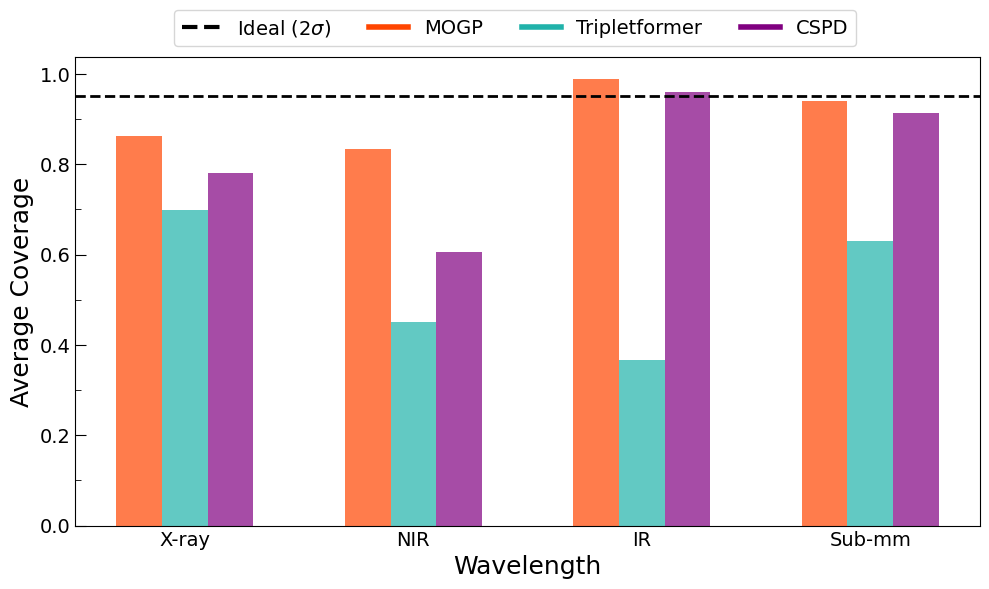

In [6]:
from matplotlib.lines import Line2D
import numpy as np
import matplotlib.pyplot as plt
import glob

# Load data from seed files
all_seeds_coverage = {}
loaded_keys = None
for filename in glob.glob('coverage_plot_data_*.npz'):
    loaded_data = np.load(filename, allow_pickle=True)
    coverage_data = loaded_data['coverage_data'].item()
    keys = loaded_data['keys']

    if loaded_keys is None:
        loaded_keys = keys

    for model, coverage_values in coverage_data.items():
        if model not in all_seeds_coverage:
            all_seeds_coverage[model] = {key: [] for key in keys}
        for i, key in enumerate(keys):
            if len(coverage_values) > i:
                all_seeds_coverage[model][key].append(coverage_values[i])

# Calculate average coverage
average_coverage = {
    model: {key: np.nanmean(values) for key, values in wavelength_data.items()}
    for model, wavelength_data in all_seeds_coverage.items()
}

# Plot settings
model_names = list(average_coverage.keys())
num_wavelengths = len(loaded_keys)
bar_width = 0.2
x = np.arange(num_wavelengths)
colors = ['#FF4500', '#20B2AA', '#800080']
labels = ['X-ray', 'NIR', 'IR', 'Sub-mm']

fig, ax = plt.subplots(figsize=(10, 6))

# Plot bars
for i, model_name in enumerate(model_names):
    avg_coverage_values = [average_coverage[model_name][key] for key in loaded_keys]
    positions = x + (i * bar_width - bar_width)
    ax.bar(positions, avg_coverage_values, bar_width, color=colors[i], alpha=0.7)

# Custom legend
legend_handles = [
    Line2D([0], [0], color='black', linestyle='--', label=r'Ideal (2$\sigma$)', linewidth=3),
    Line2D([0], [0], color='#FF4500', label='MOGP', linewidth=4),
    Line2D([0], [0], color='#20B2AA', label='Tripletformer', linewidth=4),
    Line2D([0], [0], color='#800080', label='CSPD', linewidth=4)
]

fig.legend(handles=legend_handles, loc='upper center', bbox_to_anchor=(0.52, 1.02), ncol=4, fontsize=14)

# Ideal coverage line
ax.axhline(0.95, color='black', linestyle='--', linewidth=2)

# Axis labels and ticks
ax.set_ylabel("Average Coverage", fontsize=18)
ax.set_xlabel("Wavelength", fontsize=18)
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=14)

# Major and minor ticks on y-axis
ax.set_yticks(np.linspace(0, 1, 6))
ax.set_yticks(np.linspace(0, 1, 11), minor=True)
ax.tick_params(axis='y', which='major', direction='in', length=8, labelsize=14)
ax.tick_params(axis='x', which='major', direction='in', length=0, labelsize=14)
ax.tick_params(axis='y', which='minor', direction='in', length=4, labelsize=0)

fig.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.savefig('coverage_histogram.pdf', format='pdf', bbox_inches='tight')
plt.show()


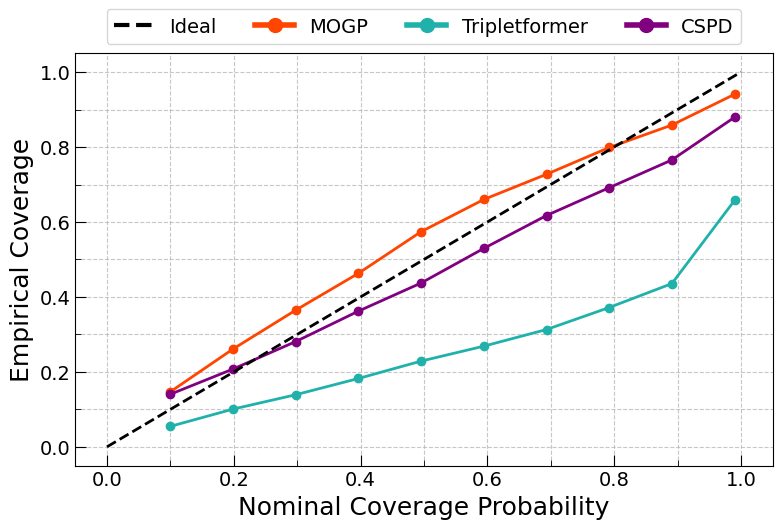

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Load the calibration data
calibration_data = np.load('final_metrics.npz', allow_pickle=True)
coverage_percentages = calibration_data['coverage_percentages']
calibration_results = calibration_data['calibration'].item()
colors = ['#FF4500', '#20B2AA', '#800080']

# Plot calibration curves
fig, ax = plt.subplots(figsize=(8, 6))

for i, (model_name, coverage_values) in enumerate(calibration_results.items()):
    ax.plot(coverage_percentages, coverage_values, color=colors[i], marker='o', linewidth=2, label=model_name)

# Ideal calibration line
ax.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Ideal Calibration')

# Major and minor ticks customization
ax.set_xticks(np.linspace(0, 1, 6))
ax.set_yticks(np.linspace(0, 1, 6))
ax.set_xticks(np.linspace(0, 1, 11), minor=True)
ax.set_yticks(np.linspace(0, 1, 11), minor=True)

ax.tick_params(axis='both', which='major', direction='in', length=8, labelsize=14)
ax.tick_params(axis='both', which='minor', direction='in', length=4, labelsize=0)

ax.set_xlabel('Nominal Coverage Probability', fontsize=18)
ax.set_ylabel('Empirical Coverage', fontsize=18)
ax.grid(True, linestyle='--', which='both', alpha=0.7)

# Custom legend
legend_handles = [
    Line2D([0], [0], color='black', label='Ideal', linestyle='dashed', linewidth=3),
    Line2D([0], [0], marker='o', color=colors[0], label='MOGP', markersize=10, linewidth=4),
    Line2D([0], [0], marker='o', color=colors[1], label='Tripletformer', markersize=10, linewidth=4),
    Line2D([0], [0], marker='o', color=colors[2], label='CSPD', markersize=10, linewidth=4)
]
ax.legend(handles=legend_handles, loc='upper center', bbox_to_anchor=(0.5, 1.13), ncol=4, fontsize=14)

plt.tight_layout(rect=[0, 0.03, 1, 0.94])
plt.savefig('coverage_line.pdf', format='pdf', bbox_inches='tight')

plt.show()

In [8]:
import numpy as np

# Load MSE data
data = np.load('final_metrics.npz', allow_pickle=True)
mse_data = data['mse_per_wavelength'].item()  # dict: {model: {wavelength: mse}}

print("=== Average MSE per Model per Wavelength ===\n")
for model_name, mse_dict in mse_data.items():
    print(f"Model: {model_name}")
    mse_values = []
    for wavelength, mse in mse_dict.items():
        print(f"  {wavelength:>7}: {mse:.5f}")
        mse_values.append(mse)
    avg_mse = np.nanmean(mse_values)
    print(f"  {'Mean':>7}: {avg_mse:.5f}\n")


=== Average MSE per Model per Wavelength ===

Model: MOGP
        X: 1.20732
      NIR: 1.11975
       IR: 0.15239
   Sub-mm: 0.37486
     Mean: 0.71358

Model: TripletFormer
        X: 1.65363
      NIR: 2.06628
       IR: 0.82876
   Sub-mm: 1.45290
     Mean: 1.50039

Model: Diffusion
        X: 1.20171
      NIR: 1.57818
       IR: 0.03824
   Sub-mm: 0.46331
     Mean: 0.82036

